### Imports and General Data

In [1]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from preprocessing import create_connection, get_files
from main import get_files, get_data, export_data
(root, data_path, presidents, president, cities, years) = get_data()

# Aggregated Monthly Sentiment 

In [3]:
# create columns
months = range(1, 13)
formatted_dates = [f'{year}-{month:02d}' for year in years for month in months]

In [4]:
def get_compound_sentiment(president):
    compound_sentiment = pd.DataFrame(index=cities, columns=formatted_dates)
    compound_col = 'Compound'
    for db_file in get_files(f'{data_path}{president}/'):
        # get date in the format YYYY-MM
        date_only = db_file[-11:-4]
        # load data
        data = pd.read_pickle(f'{data_path}{president}/{db_file}')
        # check if data has respective column
        assert compound_col in data.columns
        city = db_file.split('-')[0]
        # check if the city was extracted correctly
        assert city in cities
        # save the monthly compounded graded sentiment scoring in the compound_sentiment overview
        compound_sentiment.at[city, date_only] = data[compound_col].mean()
    # save data
    suffix = '_compound_sentiment.'
    compound_sentiment.to_pickle(f'{data_path}{president}{suffix}pkl')
    # convert compound sentiment pickle to csv
    data = pd.DataFrame(compound_sentiment)
    data.to_csv(f'{data_path}{president}{suffix}csv')
    return compound_sentiment

In [5]:
trump_compound_sentiment = get_compound_sentiment(presidents[0])
johnson_compound_sentiment = get_compound_sentiment(presidents[1])

In [6]:
# president = presidents[0]
colors = ['#910830', '#BFBFBF', '#6D0624', '#5E5E5D']

In [7]:
def plot(data, indexes, president, filename, labels='year'):
    labels = data.columns[5::12] if labels == 'year' else data.columns[::int(labels)]
    plt.figure(figsize=(14, 8))
    mpl.rcParams['font.family'] = 'sans-serif' #'serif'
    # Plot each dimension
    for i in range(len(indexes)):
        plt.plot(data.loc[indexes[i]], label=indexes[i], color=colors[i])

    # Adding titles and labels
    plt.title(f'Compounded Sentiment Scoring about {president.capitalize()} on Twitter')
    plt.ylabel('Compounded Sentiment Scoring')
    plt.xticks(labels)

    # Adding a legend
    plt.legend() #loc='upper left'
    plt.grid(color='gray', linestyle='-.', linewidth=.5)
    limit = 0.3
    plt.xlim(limit)
    alpha = .1
    plt.axhspan(0, limit, facecolor='green', alpha=alpha)
    plt.axhspan(0, limit*-1, facecolor='red', alpha=alpha)
    # Display the plot
    plt.savefig(f'visualizations/compounded_sentiment_scoring_{president}-{filename}.png')
    plt.show()

In [8]:
early_cols = trump_compound_sentiment.columns[:7]
late_cols = trump_compound_sentiment.columns[-6:]
del_cols = early_cols.append(late_cols)
del early_cols, late_cols
trump_compound_sentiment = trump_compound_sentiment.drop(columns=del_cols)
johnson_compound_sentiment = johnson_compound_sentiment.drop(columns=del_cols)

Donald Trump: 
- pits: 2019-10 (mostly Birmingham)
- peaks: 2019-12 (mostly NYC)
- fluctuating phase: 2021-04 -> 2022-04 (only England reacts positively)
- opposing reaction: 2021-04 (Birmingham and London react differently)

Boris Johnson:
- pits: 2020-08 (only Birmingham), 2022-04 (mostly Birmingham)
- peaks: 2020-04, 2021-02

---

Significant Fluctuations for Donald Trump
- Birmingham: Changes in 2019-10, 2019-11, 2020-06, 2020-07, 2021-06, 2021-09, 2021-10, 2021-11, 2021-12, 2022-01, 2022-02, 2022-03.
- London: Changes in 2020-02, 2021-06, 2021-07, 2021-09.
- LA and NYC: No significant fluctuations detected based on the threshold.

Significant Fluctuations for Boris Johnson

- Birmingham: Changes in 2020-05, 2020-08, 2020-09, 2021-03.
- London: Change in 2020-05.
- LA and NYC: No significant fluctuations detected based on the threshold.

In [9]:
# group by country
# for simplicity reasons the average is used to combine the columns of the English and American cities despite their different number of relevant tweets
trump_country = pd.DataFrame(columns=trump_compound_sentiment.columns)
trump_country.loc['England'] = trump_compound_sentiment.loc[['Birmingham', 'London']].mean()
trump_country.loc['USA'] = trump_compound_sentiment.loc[['LA', 'NYC']].mean()

johnson_country = pd.DataFrame(columns=johnson_compound_sentiment.columns)
johnson_country.loc['England'] = johnson_compound_sentiment.loc[['Birmingham', 'London']].mean()
johnson_country.loc['USA'] = johnson_compound_sentiment.loc[['LA', 'NYC']].mean()

### Variance

In [10]:
# todo calculate variation of each country/city
def get_variance(data):
    return np.var(data.T)

In [11]:
trump_compound_sentiment_var = get_variance(trump_compound_sentiment)
johnson_compound_sentiment_var = get_variance(johnson_compound_sentiment)
trump_country_var = get_variance(trump_country)
johnson_country_var = get_variance(johnson_country)

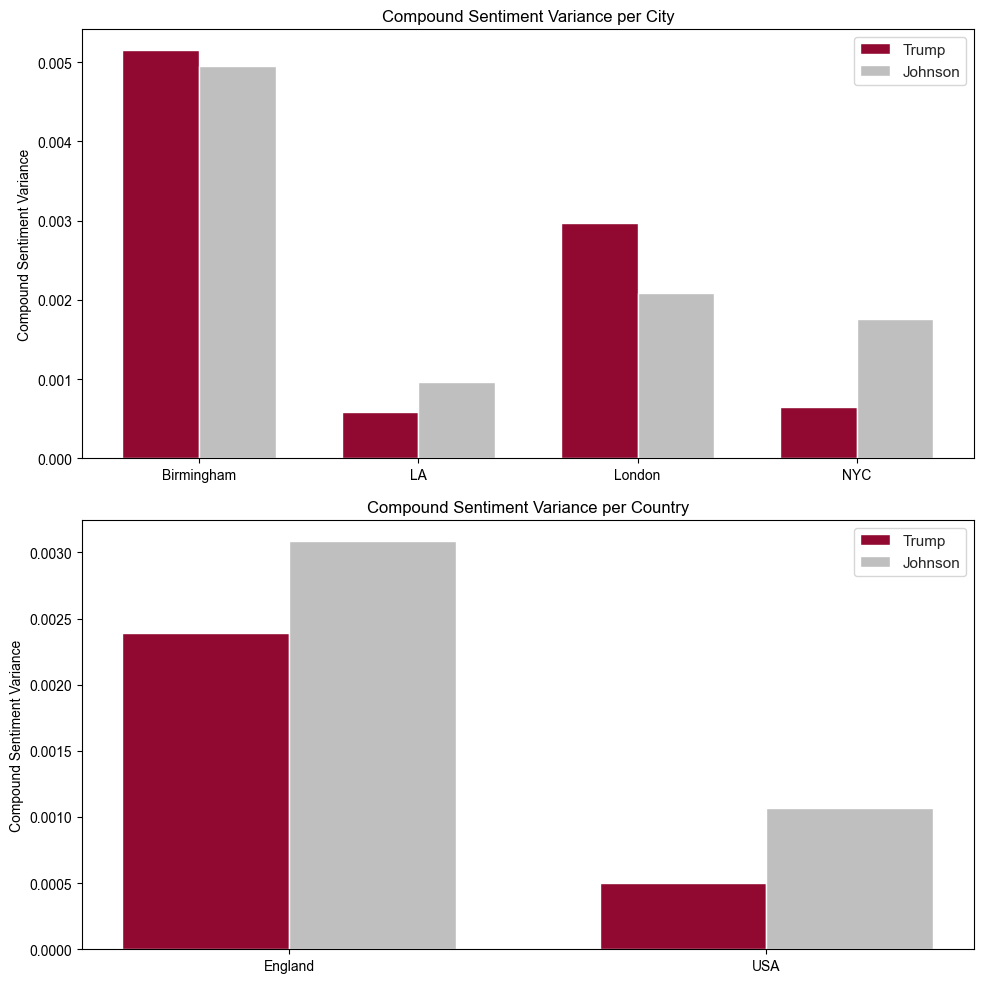

In [12]:
countries = ['England', 'USA']
# Define the bar width
bar_width = 0.35

# Define the positions of the bars
city_positions = np.arange(len(cities))
country_positions = np.arange(len(countries))

# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Set up the seaborn style for nicer plots
sns.set(style="whitegrid")

# Plot the city variances
ax[0].bar(city_positions - bar_width/2, trump_compound_sentiment_var, bar_width, label='Trump', color=colors[0])
ax[0].bar(city_positions + bar_width/2, johnson_compound_sentiment_var, bar_width, label='Johnson', color=colors[1])
ax[0].set_xticks(city_positions)
ax[0].set_xticklabels(cities)
ax[0].set_title('Compound Sentiment Variance per City')
ax[0].set_ylabel('Compound Sentiment Variance')
ax[0].legend()

# Plot the country variances
ax[1].bar(country_positions - bar_width/2, trump_country_var, bar_width, label='Trump', color=colors[0])
ax[1].bar(country_positions + bar_width/2, johnson_country_var, bar_width, label='Johnson', color=colors[1])
ax[1].set_xticks(country_positions)
ax[1].set_xticklabels(countries)
ax[1].set_title('Compound Sentiment Variance per Country')
ax[1].set_ylabel('Compound Sentiment Variance')
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.savefig('visualizations/variance.png', format='png', bbox_inches='tight')
plt.show()

### Monthly Sentiment Score

In [13]:
def plot_sentiment_with_highlights_and_timeframes(data, title, significant_points, timeframe=None, save_path=None):
    plt.figure(figsize=(15, 8))

    # Ensuring enough colors for the cities
    city_colors = colors[:len(data.columns)] if len(colors) >= len(data.columns) else colors

    # Plotting each city's sentiment over time with specific colors and highlighting specific points
    for i, city in enumerate(data.index):
        city_data = data.loc[city].dropna()
        sns.lineplot(x=city_data.index, y=city_data.values, label=city, color=city_colors[i])
        if city in significant_points:
            for date in significant_points[city]:
                if date in city_data.index:
                    plt.scatter(date, city_data[date], color=city_colors[i], s=50, marker='o')

    # Highlighting the specific timeframe with an orange background
    if timeframe:
        start_date, end_date = timeframe
        plt.axvspan(start_date, end_date, color='orange', alpha=0.1)

    # Adding a horizontal line at compound sentiment 0
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Compound Sentiment Score')

    # Adjusting x-axis to display only the years
    plt.xticks([date for date in data.columns if date.endswith("-01")], 
               [date[:4] for date in data.columns if date.endswith("-01")])

    plt.legend(title='City')
    plt.tight_layout()
    # Save the figure to a file if a save path is provided
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
    plt.show()

In [14]:
trump_significant_points = {
    'Birmingham': ['2019-10', '2021-05'],
    'London': ['2021-05']
}
johnson_significant_points = {
    'Birmingham': ['2020-08', '2022-04', '2020-04', '2021-02'],
    'NYC': ['2019-12']
}

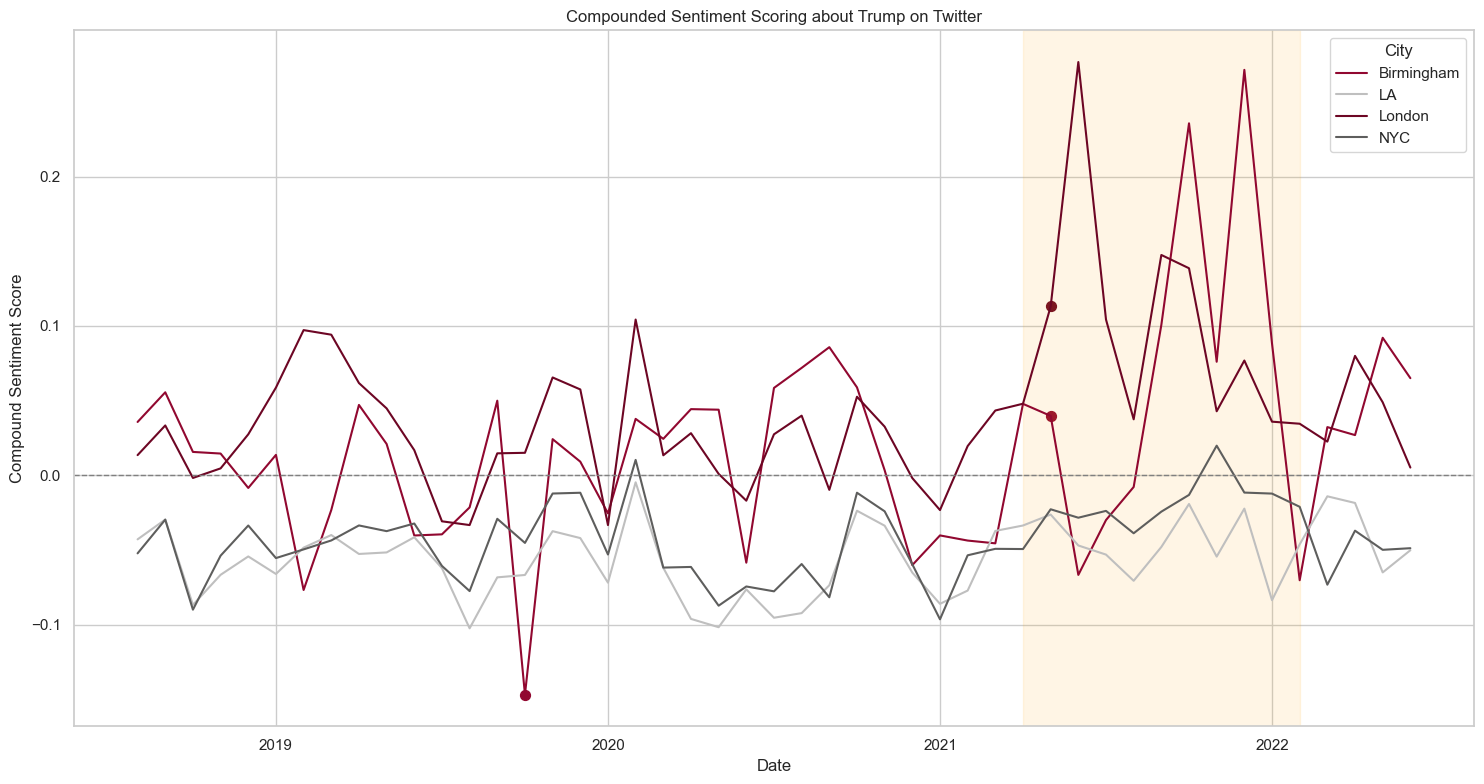

In [15]:
president = presidents[0]
plot_sentiment_with_highlights_and_timeframes(
    data=trump_compound_sentiment, 
    title=f'Compounded Sentiment Scoring about {president.capitalize()} on Twitter', 
    significant_points=trump_significant_points, 
    timeframe=('2021-04', '2022-02'), 
    save_path=f'visualizations/compounded_sentiment_scoring_{president}-cities.png')

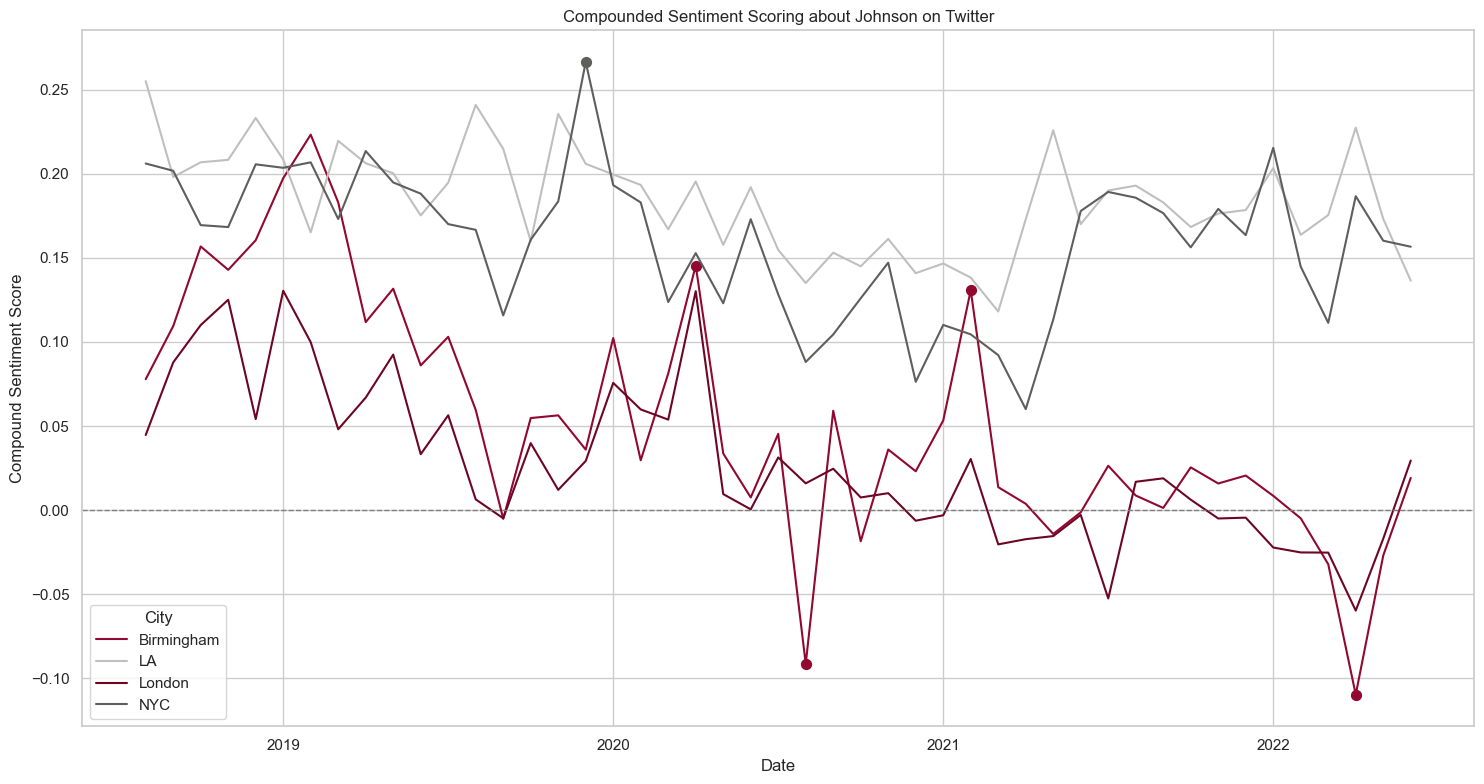

In [16]:
president = presidents[1]
plot_sentiment_with_highlights_and_timeframes(
    data=johnson_compound_sentiment,
    title=f'Compounded Sentiment Scoring about {president.capitalize()} on Twitter',
    significant_points=johnson_significant_points,
    save_path=f'visualizations/compounded_sentiment_scoring_{president}-cities.png')